In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import math
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
from torch.optim import Adam
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading a test case with some data

First we define a collision checker function.

In [2]:
def is_collision_free(x,y):
    columns = []
    columns.append(((-math.pi/2 - 0.2, -math.pi/2 + 0.2),(-0.1,0.1)))
    columns.append(((-0.2, 0.2),(-1.1,-0.9)))
    columns.append(((math.pi/2 - 0.2, math.pi/2 + 0.2),(0.9,1.1)))
    if x <= -math.pi or x > math.pi or y <= -math.pi or y > math.pi:
        raise Exception("point needs to be in [-pi,pi] x [-pi,pi]")
    for column in columns:
        in_x_col = x >= column[0][0] and x <= column[0][1]
        in_y_op = y > column[1][0] and y < column[1][1]
        if in_x_col and not in_y_op:
            return False
    return True

Now we have a look at the configuration space that this collision checker defines:

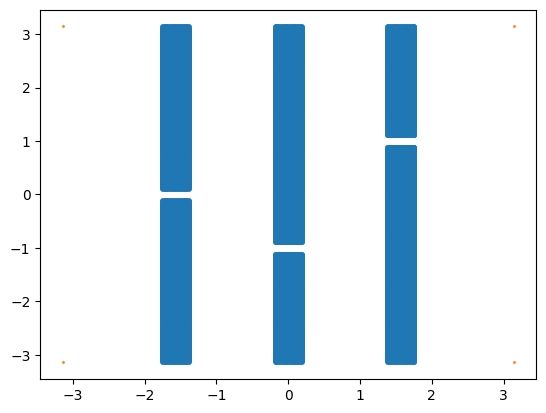

In [3]:
num_samples = 500

x_values = [ math.pi * (n/num_samples) - math.pi * (1-n/num_samples) for n in range(1,num_samples+1)]
y_values = x_values
value_grid = []
for y in y_values:
    y_section = [(x,y,is_collision_free(x,y)) for x in x_values]
    value_grid.append(y_section)

x_collisions = []
y_collisions = []
for y_row in value_grid:
    for entry in y_row:
        if not entry[2]:
            x_collisions.append(entry[0])
            y_collisions.append(entry[1])
plt.scatter(x_collisions, y_collisions, s =5)
plt.scatter([-3.1415,-3.1415, 3.1415,3.1415], [-3.1415,3.1415,-3.1415,3.1415], s = 1)

Now `value_grid` is a `500 x 500` list. It has one list for each of the 500 y-values. This list has 500 entries, one for each x-value and whether or not that point is in collision or not. Let's turn this into a `250000 x 3` tensor (250,000 data points, each with a x-value, a y-value, and a collision boolean).

In [4]:
train_data = torch.tensor([value_grid[i][j] for i in range(500) for j in range(500)])

In [5]:
train_data.shape

torch.Size([250000, 3])

In [6]:
train_data[0] # (x-coord, y-coord, collision-free (= 1))

tensor([-3.1290, -3.1290,  1.0000])

Want three models: One not considering the class of a point, one absorbing the class in the the euclidean distance, and one incorporating binary cross entropy for the class.

# Model 1
In this model, we are not considering the class of a point in the loss function at all, just the Euclidean distance between the original and reconstructed points.

In [10]:
class VAE1(nn.Module):
    def __init__(self, input_dim, latent_dim): # maybe adjust to take hidden layer dimension in as input?
        super(VAE1, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim * 2)  # Two times latent_dim for mean and log-variance
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encoding
        enc_output = self.encoder(x)
        mu, logvar = enc_output[:, :latent_dim], enc_output[:, latent_dim:]

        # Reparameterization trick
        z = self.reparameterize(mu, logvar)

        # Decoding
        dec_output = self.decoder(z)
        return dec_output, mu, logvar

In [11]:
# Define the loss function
def loss_function1(recon_x, x, mu, logvar, alpha = 1):
    # Reconstruction loss
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + alpha*kl_loss

In [12]:
# Initialize the VAE
input_dim = 2
latent_dim = 2
vae = VAE1(input_dim, latent_dim)

In [13]:
# Training data for the first model doesn't take into account the class of points.
train_data1 = train_data[:, :2]

In [15]:
# Set up optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training loop
num_epochs = 1000
losses = []
for epoch in range(num_epochs): # try implementing the minibatch gradient descent?
    # Forward pass
    recon_data, mu, logvar = vae(train_data1)

    # Compute the loss
    loss = loss_function1(recon_data, train_data1, mu, logvar, 0.01)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    # Print the loss for every few epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

# Now you can use the trained VAE for encoding and decoding

Epoch 0/1000, Loss: 1657936.25
Epoch 10/1000, Loss: 1577477.5
Epoch 20/1000, Loss: 1500754.125
Epoch 30/1000, Loss: 1406350.375
Epoch 40/1000, Loss: 1294691.75
Epoch 50/1000, Loss: 1167291.625
Epoch 60/1000, Loss: 1030539.0625
Epoch 70/1000, Loss: 891696.3125
Epoch 80/1000, Loss: 745876.875
Epoch 90/1000, Loss: 584162.0625
Epoch 100/1000, Loss: 406986.34375
Epoch 110/1000, Loss: 245066.3125
Epoch 120/1000, Loss: 143499.25
Epoch 130/1000, Loss: 109666.1484375
Epoch 140/1000, Loss: 94937.828125
Epoch 150/1000, Loss: 80424.875
Epoch 160/1000, Loss: 70695.9296875
Epoch 170/1000, Loss: 64243.8359375
Epoch 180/1000, Loss: 59112.52734375
Epoch 190/1000, Loss: 55076.8046875
Epoch 200/1000, Loss: 51866.5234375
Epoch 210/1000, Loss: 49381.3984375
Epoch 220/1000, Loss: 47262.2578125
Epoch 230/1000, Loss: 45440.5546875
Epoch 240/1000, Loss: 43898.40625
Epoch 250/1000, Loss: 42759.8046875
Epoch 260/1000, Loss: 41610.6640625
Epoch 270/1000, Loss: 40668.984375
Epoch 280/1000, Loss: 39839.18359375
Epo

Text(0, 0.5, 'loss')

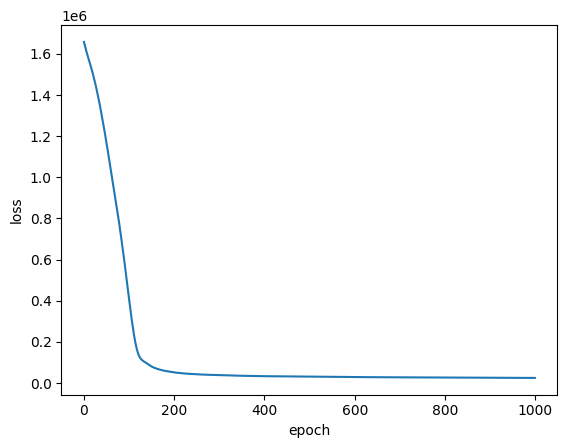

In [16]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')

In [17]:
embeds = vae.encoder(train_data1)[:, :latent_dim]

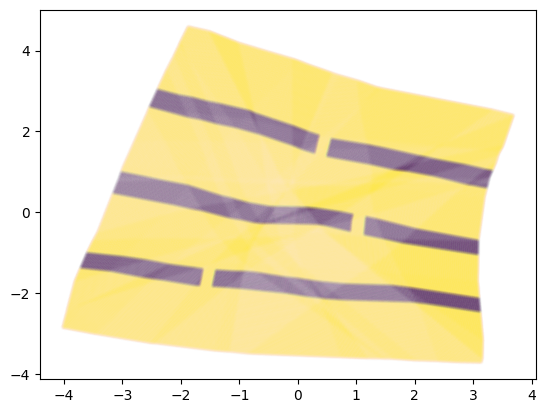

In [18]:
plt.scatter(embeds[:,0].detach(), embeds[:,1].detach(), c = train_data[:,2], alpha = 0.01, s = 5)

In [22]:
decodes = vae.decoder(embeds).detach()

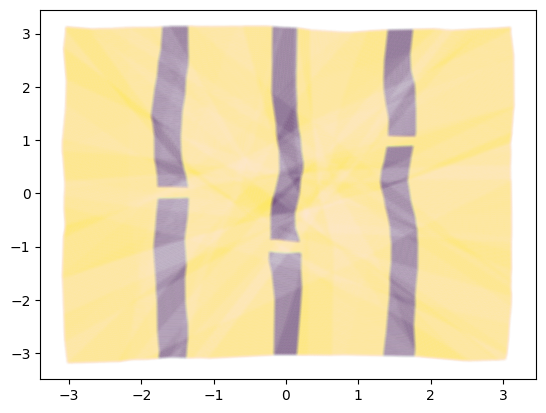

In [23]:
plt.scatter(decodes[:,0], decodes[:,1], c = train_data[:,2], alpha = 0.01, s = 5)

# EVERYTHING BELOW HERE IS NO GOOD RIGHT NOW!

### Training model 1 OLD

In [ ]:
losses = []

In [ ]:
model = model1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 50
batch_size = 2500 # for minibatches
    
model.train()

for epoch in range(epochs):
    print(epoch, end=' ')
    # build a data loader for this epoch
    loader = DataLoader(dataset = train_data1, batch_size = batch_size, shuffle = True)
    
    # loop over the batches from the loader
    for batch in loader:
        batch = batch.to(device)
        # reset optimizer's gradients
        optimizer.zero_grad()
        # run the model on all inputs
        preds = model(batch)
        # rename the different parts of the prediction
        x_hats, means, logvars = preds[0], preds[1], preds[2]
        # compute the loss function on the predictions
        loss = loss_function1(batch, x_hats, means, logvars, alpha = 1)
        losses.append(loss.item())
        # compute the gradient of the loss function
        loss.backward()
        # update the parameters based on the gradient
        optimizer.step()
    # Uncomment this to check in on the progress each epoch
    #epoch_preds = model(train_data1)
    #epoch_x_hats, epoch_means, epoch_log_vars = epoch_preds[0], epoch_preds[1], epoch_preds[2]
    #print('Epoch: ' + str(epoch) + '\t Loss: ' + str(loss_function1(train_data1, epoch_x_hats, epoch_means, epoch_log_vars)))
    #losses.append(loss_function1(train_data1, epoch_x_hats, epoch_means, epoch_log_vars).item())

In [ ]:
plt.plot(losses)

Let's look at how the model encodes the training data. We'll just plot the means of the embeddings.

Doesn't look like good separation between collision points and non-collision points like we would have hoped.

Now let's check how the decodings of the means look in the ambient space.

This looks peculiar...not sure what is going on.

# Model 2
Absorbing the class loss into the Euclidean norm

In [ ]:
class VAE2(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, device=device):
        super(VAE2, self).__init__()

        # encoder - THIS CAN BE MESSED AROUND WITH
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            #nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, latent_dim)
        self.logvar_layer = nn.Linear(latent_dim, latent_dim)
        
        # decoder - THIS CAN ALSO BE MESSED AROUND WITH
        self.decoder = nn.Sequential(
            #nn.Linear(latent_dim, latent_dim),
            #nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim)
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(logvar).to(device)      
        z = mean + torch.exp(logvar/2.)*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        x_hat[-1] = torch.sigmoid(x_hat[-1]) # now we want to make sure the third coordinate is between 0 and 1.
        return x_hat, mean, logvar

In [ ]:
model2 = VAE2(3,100,1)

In [ ]:
model2(train_data[20])

The code for the loss function is actually identical to before.

In [ ]:
def loss_function2(x, x_hat, mean, log_var, alpha = 1):
    
    # Euclidean reconstruction loss
    #reconstruction_loss = torch.sqrt(torch.sum((x_hat - x)**2)) # Euclidean distance
    
    # average square Euclidean distance reconstruction loss
    reconstruction_loss = nn.MSELoss()
    
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    #return reconstruction_loss + KLD
    return reconstruction_loss(x, x_hat) + alpha*KLD

### Training model 2

In [ ]:
losses = []

In [ ]:
model = model2
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 50
batch_size = 1000 # for minibatches
    
model.train()

for epoch in range(epochs):
    print(epoch, end=' ')
    # build a data loader for this epoch
    loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
    
    # loop over the batches from the loader
    for batch in loader:
        batch = batch.to(device)
        # reset optimizer's gradients
        optimizer.zero_grad()
        # run the model on all inputs
        preds = model(batch)
        # rename the different parts of the prediction
        x_hats, means, log_vars = preds[0], preds[1], preds[2]
        # compute the loss function on the predictions
        loss = loss_function2(batch, x_hats, means, log_vars, alpha = 0.01)
        losses.append(loss.item())
        # compute the gradient of the loss function
        loss.backward()
        # update the parameters based on the gradient
        optimizer.step()
    # Uncomment this to check in on the progress each epoch
    #epoch_preds = model(train_data1)
    #epoch_x_hats, epoch_means, epoch_log_vars = epoch_preds[0], epoch_preds[1], epoch_preds[2]
    #print('Epoch: ' + str(epoch) + '\t Loss: ' + str(loss_function1(train_data1, epoch_x_hats, epoch_means, epoch_log_vars)))
    #losses.append(loss_function1(train_data1, epoch_x_hats, epoch_means, epoch_log_vars).item())

In [ ]:
plt.plot(losses)

Let's look at how the model encodes the training data. We'll just plot the means of the embeddings.

In [ ]:
embeds = model.encode(train_data)
embed_means = embeds[0].detach().view(250000)
embed_log_vars = embeds[1].detach().view(250000)
embed_means, embed_log_vars

In [ ]:
plt.scatter(embed_means, torch.zeros_like(embed_means), c = train_data[:,2], alpha = 0.01, s = 5)

Now let's check how the decodings of the means look in the ambient space.

In [ ]:
decodes = model.decode(embeds[0]).detach()
decodes

Still weird looking...also I'm not sure why the colorbar looks all white.

In [ ]:
plt.scatter(decodes[:,0], decodes[:,1], c = decodes[:,2], alpha = 0.01, s = 5)
plt.colorbar()

WHY ARE ALL THE DECODING MEANS JUST COMING OUT AS STRAIGHT LINES??

NEXT PART IS INCOMPLETE!

# Model 3 INCOMPLETE!
A separate binary cross entropy loss part for the class

In [ ]:
class VAE3(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, device=device):
        super(VAE3, self).__init__()

        # encoder - THIS CAN BE MESSED AROUND WITH
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, latent_dim)
        self.logvar_layer = nn.Linear(latent_dim, latent_dim)
        
        # decoder - THIS CAN ALSO BE MESSED AROUND WITH
        self.point_decoder = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim)
            nn.Sigmoid()
            )
        
        # CLASS decoder - THIS CAN ALSO BE MESSED AROUND WITH. This is to decode (predict) whether the pt is in collision or not.
        self.label_decoder = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1), # just decoding 1 thing here: collision or not
            nn.Sigmoid() # make the prediction a probability
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    #def decode(self, x):
    #    return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        #x_hat = self.decode(z)
        x_hat = self.point_decoder(z)
        x_hat[2] = sigmoid(x_hat[2])
        x_hat[0] = (sigmoid(x_hat[0]) - 0.5)*2*math.pi
        x_hat[1] = (sigmoid(x_hat[1]) - 0.5)*2*math.pi
        #label_hat = self.label_decoder(z)
        return x_hat, mean, logvar

In [ ]:
def loss_function3(x, x_hat, mean, log_var, alpha = 1, beta = 1):
    # alpha and beta are parameters to determine how much to weight Euclidean distance and correct classification
    
    for i in range(len(x_hat)):
        if i < len(x_hat) - 1:
            if x_hat[i] > math.pi or x_hat[i] <= -math.pi:
                return 1e6
        else:
            if x_hat[i] < 0 or x_hat[i] > 1:
                return 1e6
    
    # Euclidean reconstruction loss
    dist = torch.sqrt(torch.sum((x_hat - x)**2)) # Euclidean distance
    reconstruction_loss = alpha*dist
    
    # BCE label loss
    #label = is_collision_free(x) # or label(x)
    #pred = COLLISIONCHECKER(x_hat)
    
    # need probabilities that it is collision and not collision. So we need a collision predictor
    # IDEA: make the COLLISIONCHECKER function a neural network classifier so that we can backprop.
    
    #label_loss = beta*nn.functional.binary_cross_entropy(label, label_hat, reduction='sum')
    
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    #return reconstruction_loss + label_loss + KLD
    return torch.tensor(reconstruction_loss + KLD)

In [ ]:
m = torch.tensor(2)*torch.pi*(nn.Sigmoid() - torch.tensor(0.5))

In [ ]:
m(torch.tensor(3))

In [ ]:
torch.pi